# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

План проекта:

Подготовим данные.
Изучим полученные файлы.\
Проверим, что эффективность обогащения рассчитана правильно.\
Проанализируем признаки, недоступные в тестовой выборке.\
Проведем предобработку данных.\
Проанализируем данные.\
Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. \
Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. \
Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. \
Построим модель\
Напишем функцию для вычисления итоговой sMAPE.\
Обучим разные модели и оцените их качество кросс-валидацией. \
Выберем лучшую модель и проверим её на тестовой выборке. 

## Подготовка данных

### Откроем файлы и изучим их.

In [44]:
# Импортируем необходимые библиотеки

import pandas as pd
import numpy as np

from numpy.random import RandomState
state = np.random.RandomState(12345)

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Lasso

from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Прочитаем файлы данных
train = pd.read_csv('/datasets/gold_recovery_train_new.csv') # обучающая выборка;
test = pd.read_csv('/datasets/gold_recovery_test_new.csv') # тестовая выборка;
full = pd.read_csv('/datasets/gold_recovery_full_new.csv') # исходные данные

In [4]:
# Создадим функцию для изучения полученных данных
def read_data(data):
    data.shape
    print('Количество стобцов:', data.shape[1])
    print('Количество строк:', data.shape[0])
    print('Количество дупликатов', data.duplicated().sum())
    display(data.head())
    display(data.describe())
    data.info()

In [5]:
print('Тренировочная выборка')
print('')
read_data(train)

Тренировочная выборка

Количество стобцов: 87
Количество строк: 14149
Количество дупликатов 0


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,14117.000000,14149.000000,14049.000000,14149.000000,14063.000000,13863.000000,14149.000000,14148.000000,14134.000000,14103.000000,14149.000000,14145.000000,14148.000000,14145.000000,14148.000000,14147.000000,14148.000000,14146.000000,14148.000000,1.414800e+04,14148.000000,14148.000000,14149.000000,14149.000000,14049.000000,14141.000000,14005.000000,14071.000000,14149.000000,14120.000000,14141.000000,14113.000000,13721.000000,14149.000000,14149.000000,14127.000000,14149.000000,14149.000000,14148.000000,14149.000000,14149.000000,14149.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14149.000000,14149.000000,13713.000000,14149.000000,14149.000000,14149.000000,14147.000000,14139.000000,12544.000000,14149.000000,13932.000000,14148.000000,14128.000000,14148.000000,14145.000000,14148.000000,14148.000000,14148.000000,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [6]:
print('Тестовая выборка')
read_data(test)

Тестовая выборка
Количество стобцов: 53
Количество строк: 5290
Количество дупликатов 0


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5287.000000,5289.000000,5269.000000,5290.000000,5285.000000,5290.000000,5282.000000,5265.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5287.000000,5290.000000,5288.000000,5290.000000,5281.000000,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,1.544844e+03,-500.199527,9.371940,3.798082,489.800620,55.951097,37.716648,9.334682,13.855759,6.467745,13.922328,6.512103,1053.400166,-395.732530,1318.926879,-475.241428,1301.595477,-474.836671,1214.847960,-475.682272,1056.648995,-469.029688,997.949719,-470.482465,26.312630,-502.750897,21.949119,-501.987097,25.402926,-507.490314,2.098211e+01,-506.627916,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,1.247731e+02,31.045257,1.926264,0.954859,108.036326,19.081758,5.491415,1.619521,3.350852,1.065114,3.223769,0.886989,121.139309,91.085505,156.450366,45.649466,171.269667,45.859866,185.763319,47.844967,131.542839,59.325990,128.218869,60.759318,3.429852,28.756505,4.354961,34.582722,6.526457,47.620908,6.736179e+00,44.528673,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,4.039220e-32,-799.794250,0.568441,0.273677,0.002986,0.046369,1.393488,0.568632,0.001147,0.000568,0.000077,0.006985,-0.042069,-657.949759,-0.721806,-650.245277,-0.056636,-647.544439,-0.992219,-648.390665,-1.982295,-649.267537,-2.593390,-649.949283,0.20

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [7]:
print('Полная выборка')
read_data(full)

Полная выборка
Количество стобцов: 87
Количество строк: 19439
Количество дупликатов 0


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,19402.000000,19439.000000,19335.000000,19439.000000,19323.000000,19069.000000,19439.000000,19435.000000,19418.000000,19377.000000,19439.000000,1.943500e+04,19438.000000,1.943500e+04,19438.000000,1.943700e+04,19438.000000,1.943600e+04,19438.000000,1.943700e+04,19437.000000,19437.000000,19439.000000,19439.000000,19339.000000,19428.000000,19294.000000,19340.000000,19439.000000,19405.000000,19431.000000,19395.000000,18986.000000,19439.000000,19439.000000,19416.000000,19439.000000,19439.000000,19438.000000,19439.000000,19439.000000,19439.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19439.000000,19439.000000,19003.000000,19439.000000,19439.000000,19439.000000,19437.000000,19427.000000,17691.000000,19439.000000,19219.000000,19438.000000,19416.000000,19438.000000,19426.000000,19438.000000,19438.000000,19438.000000,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


По результатам первичного изучения:
1. В данных есть пропуски.
2. В тестовой выборке отсутствуют признаки, которые есть в тренировочной и полной выборках.
3. Явные дубликаты в выборках отсутствуют.

### Проверим, что эффективность обогащения рассчитана правильно.

Эффективность обогащения будем считать по формуле: recovery = ((C x (F - T)) / (F x (C - T))) x 100 %

In [8]:
C = train['rougher.output.concentrate_au'] # доля золота в концентрате после флотации/очистки;
F = train['rougher.input.feed_au'] # доля золота в сырье/концентрате до флотации/очистки;
T = train['rougher.output.tail_au'] # доля золота в отвальных хвостах после флотации/очистки.

In [9]:
# Вычислим эффективность обогащения 
recovery = ((C * (F - T)) / (F * (C - T))) * 100

In [10]:
# Найдем MAE между выполненными расчётами и значением признака
print('MAE = ', mean_absolute_error(recovery, train['rougher.output.recovery']))

MAE =  9.73512347450521e-15


Вывод: значение МАЕ между расчетными данными и признаком rougher.output.recovery очень мало, значит, признак в представленных данных рассчитан верно.

### Проанализируем признаки, недоступные в тестовой выборке.

In [11]:
diff_future = pd.DataFrame(set(train.columns) - set(test.columns))
display(diff_future)

,0
0,rougher.calculation.sulfate_to_au_concentrate
1,final.output.recovery
2,final.output.tail_ag
3,rougher.output.tail_ag
4,rougher.output.concentrate_pb
5,rougher.calculation.floatbank10_sulfate_to_au_...
6,final.output.tail_sol
7,rougher.output.concentrate_ag
8,primary_cleaner.output.concentrate_sol
9,final.output.tail_au


Выводы:
1. Все отсутствующие в тестовой выборке признаки числовые.
2. Признаки, отсутствующие в тестовой выборке, относятся к 2 типам: это расчетные характеристики (признаки calculation) и относящиеся к параметрам продукта (признаки output).

### Проведем предобработку данных.

In [12]:
# Проверим количество пропусков до проведения предобработки
print('Количество пропусков в выборке train до обработки в процентах')
print((train.isna().sum().sort_values(ascending=False) / train.shape[0]) * 100)
print('Количество пропусков в выборке test до обработки в процентах')
print((test.isna().sum().sort_values(ascending=False) / test.shape[0]) * 100)

Количество пропусков в выборке train до обработки в процентах
secondary_cleaner.output.tail_sol                     11.343558
rougher.state.floatbank10_e_air                        3.081490
rougher.input.floatbank11_xanthate                     3.024949
primary_cleaner.output.concentrate_sol                 2.021344
secondary_cleaner.state.floatbank2_a_air               1.533677
final.output.concentrate_sol                           1.491271
rougher.input.feed_size                                1.017740
primary_cleaner.input.xanthate                         0.706764
rougher.input.feed_pb                                  0.706764
final.output.tail_pb                                   0.706764
primary_cleaner.output.concentrate_pb                  0.607817
rougher.input.feed_sol                                 0.551276
primary_cleaner.output.tail_sol                        0.325111
rougher.input.floatbank11_sulfate                      0.254435
primary_cleaner.input.depressant          

В условии сказано, что данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи. Заполним пропуски с использованием метода bfill.

In [13]:
train.bfill(axis='rows', inplace=True)

In [14]:
test.bfill(axis='rows', inplace=True)

In [15]:
# Проверим количество пропусков после предобработки
print('Количество пропусков в выборке train после обработки в процентах')
print((train.isna().sum().sort_values(ascending=False) / train.shape[0]) * 100)
print('Количество пропусков в выборке test после обработки в процентах')
print((test.isna().sum().sort_values(ascending=False) / test.shape[0]) * 100)

Количество пропусков в выборке train после обработки в процентах
date                                                  0.0
rougher.state.floatbank10_b_air                       0.0
rougher.state.floatbank10_f_air                       0.0
rougher.state.floatbank10_e_level                     0.0
rougher.state.floatbank10_e_air                       0.0
rougher.state.floatbank10_d_level                     0.0
rougher.state.floatbank10_d_air                       0.0
rougher.state.floatbank10_c_level                     0.0
rougher.state.floatbank10_c_air                       0.0
rougher.state.floatbank10_b_level                     0.0
rougher.state.floatbank10_a_level                     0.0
secondary_cleaner.output.tail_ag                      0.0
rougher.state.floatbank10_a_air                       0.0
rougher.output.tail_au                                0.0
rougher.output.tail_sol                               0.0
rougher.output.tail_pb                                0.0
rougher

Общий вывод по этапу:\
Изучены данные.\
Проверена правильность расчетов эффективности обогащения.\
Проведена предобработка данных. 

## Анализ данных

### Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. 

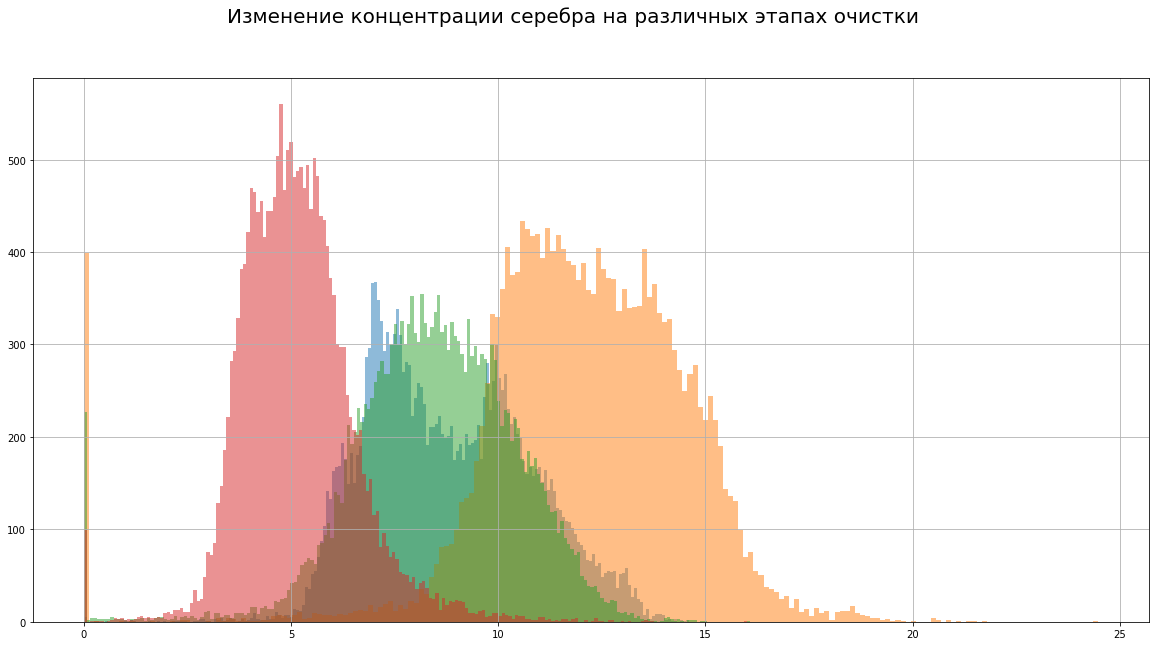

In [16]:
full['rougher.input.feed_ag'].hist(linewidth=3, bins=200, alpha=0.5, grid=True, figsize=(20, 10))
full['rougher.output.concentrate_ag'].hist(linewidth=3, bins=200, alpha=0.5, grid=True, figsize=(20, 10))
full['primary_cleaner.output.concentrate_ag'].hist(linewidth=3, bins=200, alpha=0.5, grid=True, figsize=(20, 10))
full['final.output.concentrate_ag'].hist(linewidth=3, bins=200, alpha=0.5, grid=True, figsize=(20, 10))
plt.suptitle('Изменение концентрации серебра на различных этапах очистки', fontsize=20)
plt.show()

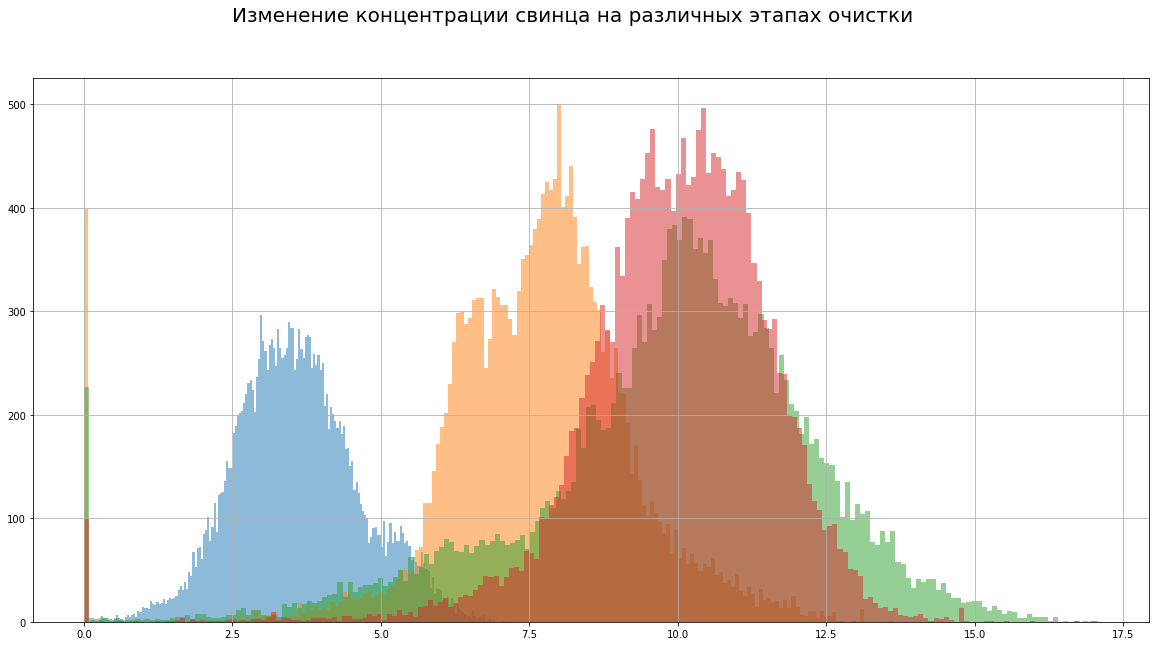

In [17]:
full['rougher.input.feed_pb'].hist(linewidth=3, bins=200, alpha=0.5, grid=True, figsize=(20, 10))
full['rougher.output.concentrate_pb'].hist(linewidth=3, bins=200, alpha=0.5, grid=True, figsize=(20, 10))
full['primary_cleaner.output.concentrate_pb'].hist(linewidth=3, bins=200, alpha=0.5, grid=True, figsize=(20, 10))
full['final.output.concentrate_pb'].hist(linewidth=3, bins=200, alpha=0.5, grid=True, figsize=(20, 10))
plt.suptitle('Изменение концентрации свинца на различных этапах очистки', fontsize=20)
plt.show()

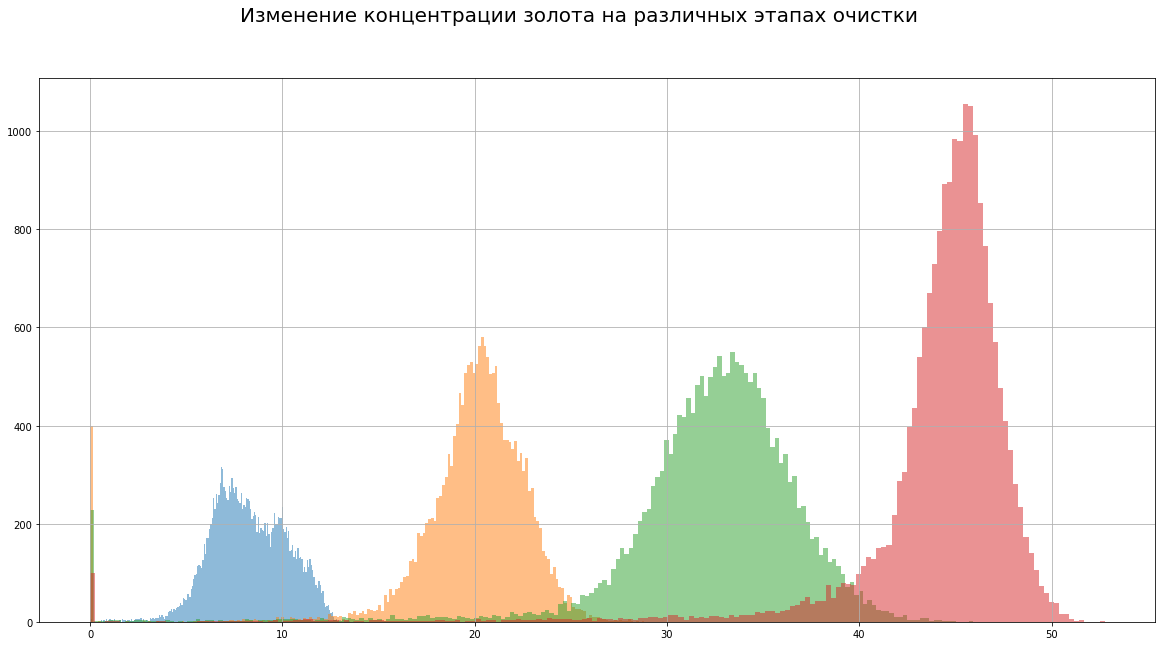

In [18]:
full['rougher.input.feed_au'].hist(linewidth=3, bins=200, alpha=0.5, grid=True, figsize=(20, 10))
full['rougher.output.concentrate_au'].hist(linewidth=3, bins=200, alpha=0.5, grid=True, figsize=(20, 10))
full['primary_cleaner.output.concentrate_au'].hist(linewidth=3, bins=200, alpha=0.5, grid=True, figsize=(20, 10))
full['final.output.concentrate_au'].hist(linewidth=3, bins=200, alpha=0.5, grid=True, figsize=(20, 10))
plt.suptitle('Изменение концентрации золота на различных этапах очистки', fontsize=20)
plt.show()

Имеем нормальное распределение, однако имеются выбросы в районе нулевых отметок.

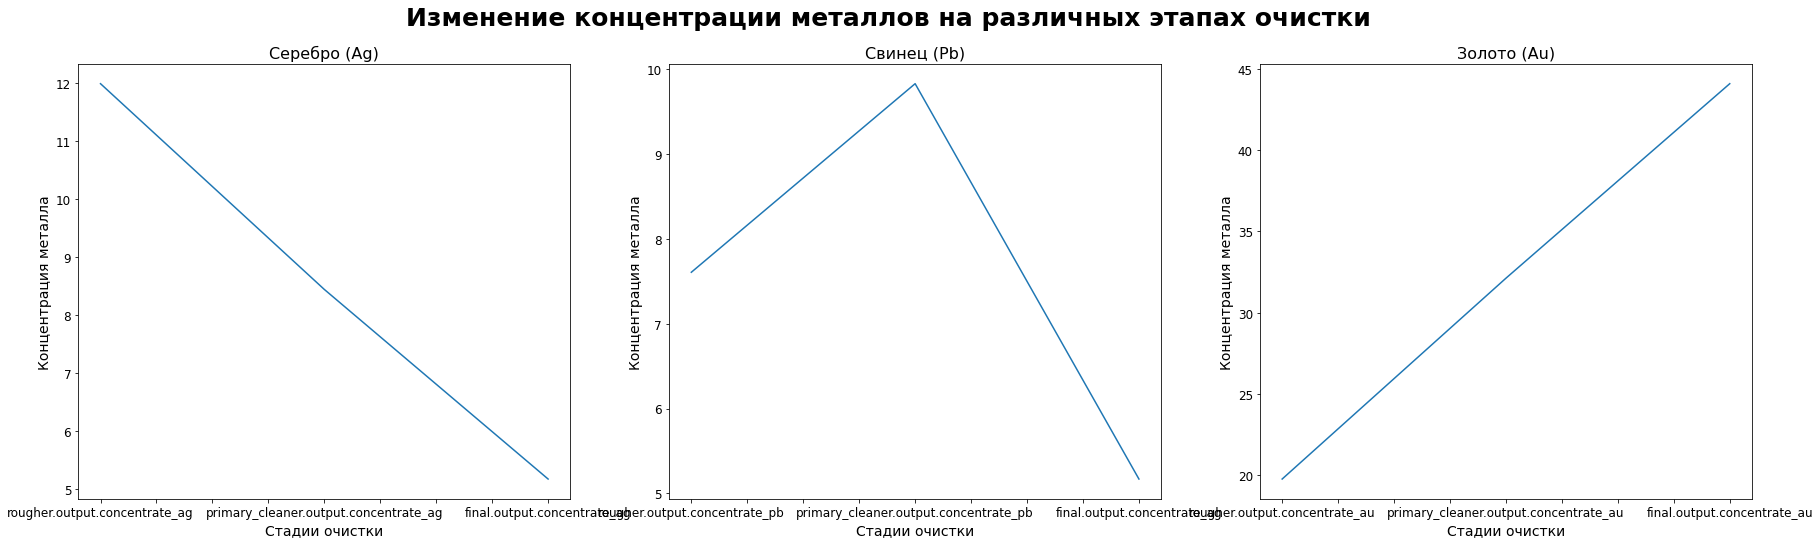

In [19]:
# Построим графики средних концентраций  для каждого металла.

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, linewidth=3, figsize=(30, 8)) 

full[['rougher.output.concentrate_ag', 
     'primary_cleaner.output.concentrate_ag',
     'final.output.concentrate_ag']].mean().plot(
    ax=ax1, subplots=True, fontsize=12)

ax1.set_title('Серебро (Ag)', fontsize=16)
ax1.set_ylabel('Концентрация металла', fontsize=14)
ax1.set_xlabel('Стадии очистки', fontsize=14)

full[['rougher.output.concentrate_pb', 
     'primary_cleaner.output.concentrate_pb',
     'final.output.concentrate_ag']].mean().plot(
    ax=ax2, subplots=True, fontsize=12)

ax2.set_title('Свинец (Pb)', fontsize=16)
ax2.set_ylabel('Концентрация металла', fontsize=14)
ax2.set_xlabel('Стадии очистки', fontsize=14)

full[['rougher.output.concentrate_au', 
     'primary_cleaner.output.concentrate_au',
     'final.output.concentrate_au']].mean().plot(
    ax=ax3, subplots=True, fontsize=12)

ax3.set_title('Золото (Au)', fontsize=16)
ax3.set_ylabel('Концентрация металла', fontsize=14)
ax3.set_xlabel('Стадии очистки', fontsize=14)


plt.suptitle('Изменение концентрации металлов на различных этапах очистки', fontsize=25, fontweight='bold')
plt.show()

Концентрация серебра по мере очистки снижается, концентрация свинца после флотации резко растет, далее резко уменьшается. Концентрация золота линейно растет по мере очистки.

### Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. 

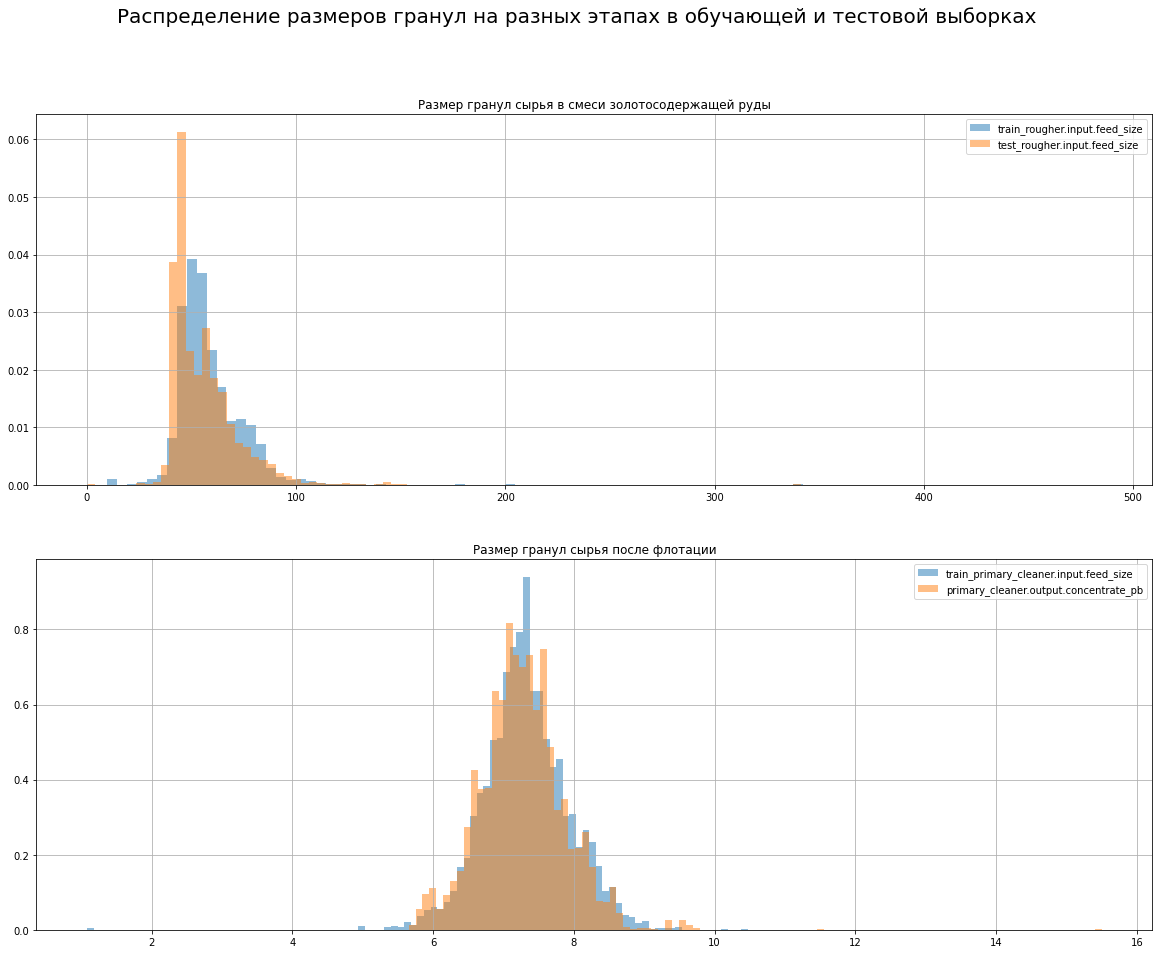

In [20]:
fig, ax = plt.subplots(2, 1)
fig.set_figheight(15)
fig.set_figwidth(20)
fig.suptitle('Распределение размеров гранул на разных этапах в обучающей и тестовой выборках', size=20)

ax[0].hist(train['rougher.input.feed_size'], bins=100, alpha = 0.5, 
           label = 'train_rougher.input.feed_size', density=True)
ax[0].hist(test['rougher.input.feed_size'], bins=100, alpha = 0.5, 
           label = 'test_rougher.input.feed_size', density=True)
ax[0].legend()
ax[0].set_title('Размер гранул сырья в смеси золотосодержащей руды')
ax[0].grid()

ax[1].hist(train['primary_cleaner.input.feed_size'], bins=100, alpha = 0.5, 
           label = 'train_primary_cleaner.input.feed_size', density=True)
ax[1].hist(test['primary_cleaner.input.feed_size'], bins=100, alpha = 0.5, 
           label = 'primary_cleaner.output.concentrate_pb', density=True)
ax[1].legend()
ax[1].set_title('Размер гранул сырья после флотации')
ax[1].grid()

plt.show()

In [21]:
train['primary_cleaner.input.feed_size'].describe()

count    14149.000000
mean         7.322310
std          0.614062
min          1.080000
25%          6.960000
50%          7.290000
75%          7.700000
max         10.470000
Name: primary_cleaner.input.feed_size, dtype: float64

In [22]:
test['primary_cleaner.input.feed_size'].describe()

count    5290.000000
mean        7.266339
std         0.610219
min         5.650000
25%         6.890000
50%         7.250000
75%         7.600000
max        15.500000
Name: primary_cleaner.input.feed_size, dtype: float64

В целом распределения похожи, размеры частиц практически одни и те же, средние значения также недалеко друг от друга. Предполагаем, что модель будет оценивать правильно.

### Исследуем суммарную концентрацию всех веществ на разных стадиях

#### В сырье

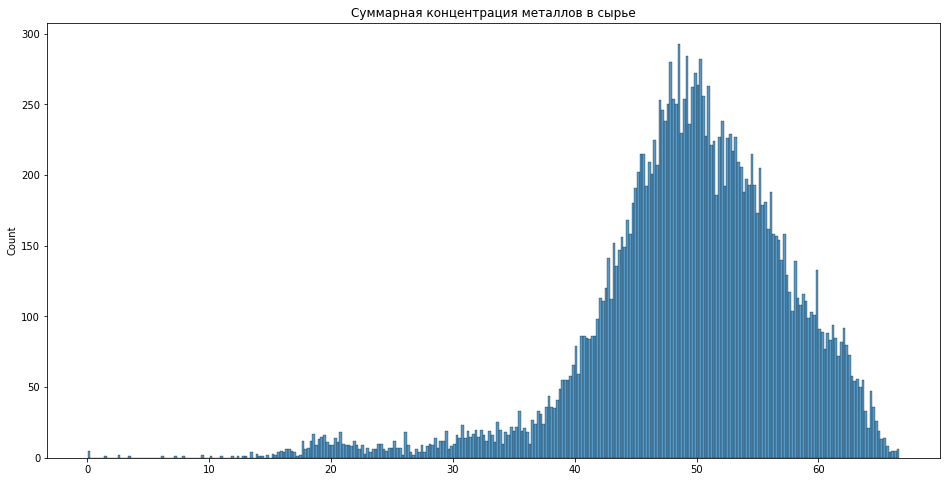

In [23]:
# Построим гистограмму для суммарной концентрации всех веществ в сырье
plt.subplots(figsize = (16,8))
sns.histplot(full[['rougher.input.feed_ag', 
                   'rougher.input.feed_pb',
                   'rougher.output.concentrate_sol',
                   'rougher.input.feed_au']].sum(axis=1), fill=True, bins=300)
plt.title('Суммарная концентрация всех веществ в сырье')
plt.show()

#### В черновом концентрате

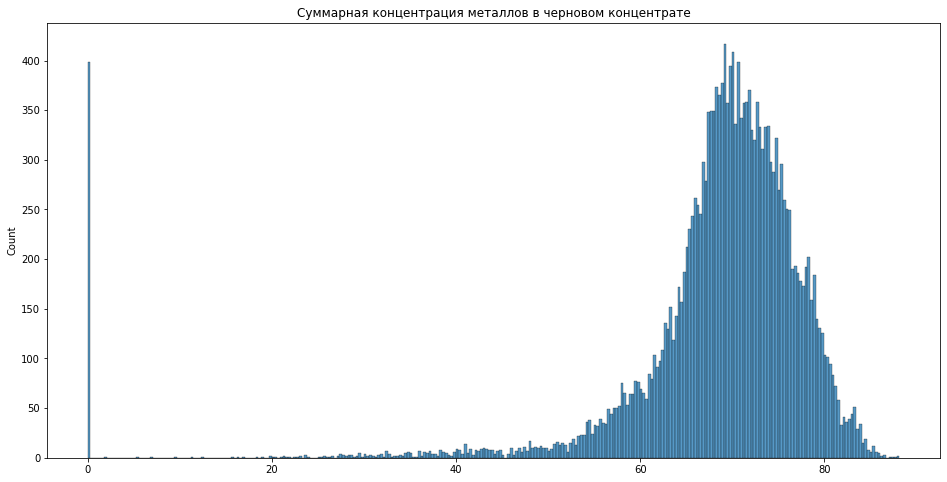

In [24]:
plt.subplots(figsize = (16,8))
sns.histplot(full[['rougher.output.concentrate_pb', 
                   'rougher.output.concentrate_ag', 
                   'rougher.output.concentrate_sol',
                   'rougher.output.concentrate_au']].sum(axis=1), fill=True, bins=300)
plt.title('Суммарная концентрация всех веществ в черновом концентрате')
plt.show()


#### В финальном концентрате

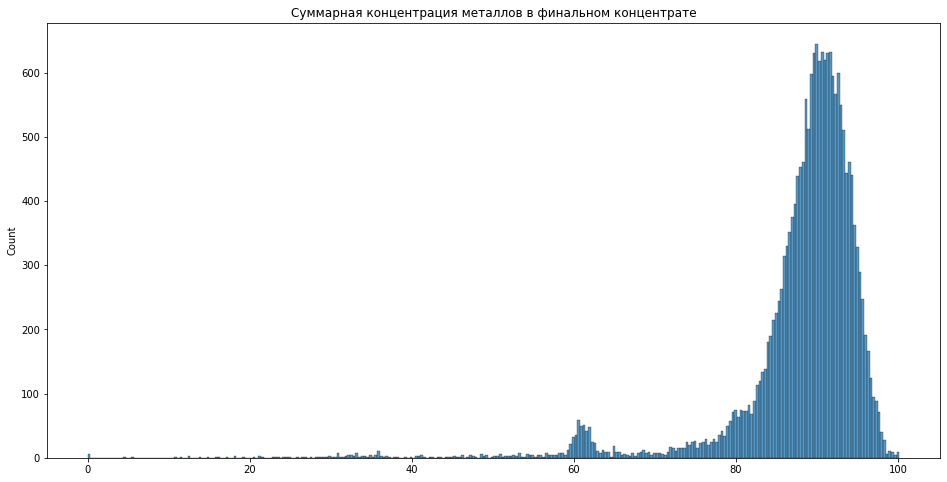

In [25]:
plt.subplots(figsize = (16,8))
sns.histplot(full[['final.output.concentrate_pb', 
                   'final.output.concentrate_ag', 
                   'rougher.output.concentrate_sol',
                   'final.output.concentrate_au']].sum(axis=1), fill=True, bins=300)
plt.title('Суммарная концентрация всех веществ в финальном концентрате')
plt.show()

In [26]:
full[['final.output.concentrate_pb', 
                   'final.output.concentrate_ag', 
                   'rougher.output.concentrate_sol',
                   'final.output.concentrate_au']].describe()

,final.output.concentrate_pb,final.output.concentrate_ag,rougher.output.concentrate_sol,final.output.concentrate_au
count,19438.000000,19438.000000,19416.000000,19439.000000
mean,9.978895,5.168470,28.805571,44.076513
std,1.669240,1.372348,5.944207,5.129784
min,0.000000,0.000000,0.000000,0.000000
25%,9.137262,4.251240,27.224120,43.402215
50%,10.102433,5.066094,29.835345,45.011244
75%,11.035769,5.895527,32.189933,46.275313
max,17.031899,16.001945,38.351193,52.756638


Мы видим аномалии в районе нулевых отметок. Один из вариантов решения является исключение выбросов, но это следует делать, только если мы можем  утверждать (почти с уверенностью), почему такие точки недействительны (например, сломалось измерительное оборудование, метод измерения по какой-то причине был ненадежным, ...). Условиями задачи такие случаи не описаны, получить данные самостоятельно не представляется возможным.\
Проблема с удалением выбросов состоит в том, что для определения того, какие точки являются выбросами, необходимо иметь хорошую модель того, что является или не является «хорошими данными». Если мы не уверены в модели (какие факторы должны быть включены, какую структуру имеет модель, каковы предположения относительно шума, ...), то мы не можем быть уверены в своих выбросах. Попробуем обучать модели на предоставленных данных, удалив только те признаки, которые точно не влияют на предсказания моделей.

## Модель

Подготовим выборки для обучения и проверки модели

In [27]:
# Добавим в  выборку целевые признаки
test = test.merge(full[['date', 
                        'rougher.output.recovery', 
                        'final.output.recovery']], 
                  how = 'left', on = 'date')

# Удалим из выборок столбцы с датой, для модели он не понадобится
test.drop(['date'], axis=1, inplace=True)
train.drop(['date'], axis=1, inplace=True)

# Удалим из тренировочной выборки те признаки, которых нет в тестовой
train = train.drop(set(train.columns)-set(test.columns), axis=1)

### Напишем функцию для вычисления итоговой sMAPE.

In [28]:
def calc_smape(predict,target):
    
    predict_rougher = predict[:,0]
    target_rougher = target[:,0]
    
    predict_final = predict[:,1]
    target_final = target[:,1]
    
    smape_rougher = np.sum(abs(target_rougher - predict_rougher) / ((abs(target_rougher) + abs(predict_rougher)) / 2))
    
    smape_rougher = smape_rougher / len(target_rougher) * 100
       
    smape_final = np.sum(abs(target_final - predict_final) / ((abs(target_final) + abs(predict_final)) / 2))
    smape_final = smape_final / len(target_final) * 100
    
    smape = 0.25 * smape_rougher + 0.75 * smape_final
    
    return smape

### Обучим разные модели и оценим их качество кросс-валидацией.

In [29]:
# Создаем отдельные переменные для признаков

features_train = train.drop(['rougher.output.recovery', 'final.output.recovery'], axis='columns')
target_train = train[['rougher.output.recovery', 'final.output.recovery']]
features_test = test.drop(['rougher.output.recovery', 'final.output.recovery'], axis='columns')
target_test = test[['rougher.output.recovery', 'final.output.recovery']]

In [30]:
# Стандартизируем данные
# Обучаем StandartScaler на обучающей выборке

scaler = StandardScaler()
scaler.fit(features_train)

# Преобразуем обучающий и тестовый наборы данных

features_train_scaler = scaler.transform(features_train)
features_test_scaler = scaler.transform(features_test)

In [31]:
# Создаем скорер метрики качества
smape_scorer = make_scorer(calc_smape, greater_is_better=False)

#### Модель линейная регрессия

In [32]:
%%time

# Построим модель для линейной регрессии и сделаем кросс-валидацию методом cross_val_score

model = LinearRegression()
model.fit(features_train_scaler, target_train)
smape = cross_val_score(model, 
                        features_train_scaler, 
                        np.array(target_train), 
                        scoring = smape_scorer, cv=6).mean()
print('Лучшее значение sMAPE для линейной регрессии:', abs(smape))

Лучшее значение sMAPE для линейной регрессии: 12.352214473449466
CPU times: user 1.13 s, sys: 2.92 s, total: 4.05 s
Wall time: 4.01 s


#### Дерево решений

In [33]:
%%time

param_dist = {'max_depth' : range(1,25,2)}
model = DecisionTreeRegressor(random_state = state)

grid = RandomizedSearchCV(model, param_dist,
                                      random_state = state,
                                      scoring= smape_scorer)

best_model = grid.fit(features_train_scaler, np.array(target_train))
print(best_model.best_estimator_)

DecisionTreeRegressor(max_depth=4,
                      random_state=RandomState(MT19937) at 0x7F7F6EF4C640)
CPU times: user 32.2 s, sys: 43.5 ms, total: 32.2 s
Wall time: 32.5 s


In [34]:
# Кросс-валидация DecisionTreeRegressor
model = DecisionTreeRegressor(random_state = state, max_depth=4)

score = cross_val_score(model, features_train_scaler, np.array(target_train), scoring = smape_scorer, cv=6).mean()
print('Лучшее значение sMAPE для дерева решений:', abs(score))

Лучшее значение sMAPE для дерева решений: 11.303646569168622


#### Случайный лес

In [35]:
%%time

param_dist = {
        'n_estimators' : range(50, 250, 10),
        'max_depth' : range(1,25,2),
}

model = RandomForestRegressor(random_state = state)

grid = RandomizedSearchCV(model, param_dist, random_state = state, scoring = smape_scorer)

best_model = grid.fit(features_train_scaler, np.array(target_train))
print(best_model.best_estimator_)

RandomForestRegressor(max_depth=5, n_estimators=170,
                      random_state=RandomState(MT19937) at 0x7F7F6EF4C440)
CPU times: user 39min 30s, sys: 2.89 s, total: 39min 32s
Wall time: 39min 36s


In [42]:
%%time

model = RandomForestRegressor(random_state = state, max_depth = 5, n_estimators = 170)

smape = cross_val_score(model, features_train_scaler, np.array(target_train), scoring = smape_scorer, cv=6).mean()
print('Лучшее значение sMAPE для случайного леса:', abs(smape))

Лучшее значение sMAPE для случайного леса: 10.41556808365448
CPU times: user 3min 20s, sys: 264 ms, total: 3min 20s
Wall time: 3min 20s


По результатам проверки лучшей моделью признаем модель линейной регрессии. Ее мы и предложим заказчику для работы.

### Проверка лучшей модели на тестовой выборке

In [47]:
model = LinearRegression()
model.fit(features_train_scaler, target_train)
predictions = model.predict(features_test_scaler)
smape = calc_smape(predictions, np.array(target_test))
print('sMAPE LinearRegression лучшей модели на тестовых данных:', smape)

sMAPE LinearRegression лучшей модели на тестовых данных: 10.059358717777187


### Проверим модель на адекватность

In [38]:
dummy = DummyRegressor(strategy = 'median')
dummy.fit(features_train_scaler, target_train)
predict = dummy.predict(features_test_scaler)

smape = calc_smape(predict, np.array(target_test))
print('sMAPE константной модели:', smape)

sMAPE константной модели: 9.47991919812286


## Общий вывод по проекту

В процессе работы над проектом:
получены и изучены данные, представленные заказчиком проекта.\
Проверена правильность подсчета эффективности обогащения.\
Проанализированы признаки, недоступные в тестовой выборке.\
Проведена предобработка данных.\
Проверено и визуализировано, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. \
Сравнили распределения размеров гранул сырья на обучающей и тестовой выборках. \
Исследовали суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. \
Построим модель\
Обучены, проверены кросс-валидацией различные модели: линейная регрессия, решающее дерево и случайный лес. \
По результатам проверки выбрали лучшую модель и проверили её на тестовой выборке.\
Кроме того, проверили модель на адекватность.